# PetFinder.my - Pawpularity Contest
Date : 2021/09/23 ~ 2022/01/22

Start date : 2021/10/01 

Data : ID를 포함한 13개의 컬럼, 사진 메타데이터, 사진데이터

Metric : RMSE(평균제곱근오차)

Questions Type : 예측(Prediction)

# Exploring

1. 사진을 제외한 데이터들을 이용하여 예측.
2. 사진과 데이터들을 같이 포함하여 예측.
3. 사진만 이용하여 예측

1 :변수끼리의 관계를 중점적으로 확인

2 : 사진안에 어떠한 부분이 Pawpularity 점수에 

유의미한 영향을 끼치는지 확인(LIME)

-> 2DCNN 등등 

핵심 : 사진과 Binary 데이터들을 어떤식으로 조합하여 예측에 사용할지

# CNN

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import os
import cv2
from PIL import Image

import numpy as np
from tqdm import tqdm

In [2]:

test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [3]:
labels = train_df[['Id','Pawpularity']]

In [11]:
path = 'C:/Users/현우/Desktop/포트폴리오/Kaggle_PetFinder/train/'
sort = []
for i in tqdm(range(len(labels))):
    img = path + labels.Id.iloc[i] + '.jpg'
    img = Image.open(img)
    sort.append(list(np.array(img).shape))
    

100%|██████████████████████████████████████████████████████████████████████████████| 9912/9912 [02:29<00:00, 66.10it/s]


In [41]:
sort_df = pd.DataFrame(sort,columns=['X','Y','Z'])
sort_df.describe()

,X,Y,Z
count,9912.000000,9912.000000,9912.0
mean,904.284302,804.426251,3.0
std,156.905980,270.211921,0.0
min,113.000000,90.000000,3.0
25%,908.750000,675.000000,3.0
50%,960.000000,720.000000,3.0
75%,960.000000,960.000000,3.0
max,1280.000000,1280.000000,3.0


In [44]:
labels.iloc[:,-1]

0       63
1       42
2       28
3       15
4       72
        ..
9907    15
9908    70
9909    20
9910    20
9911    30
Name: Pawpularity, Length: 9912, dtype: int64

In [10]:
path = 'C:/Users/현우/Desktop/포트폴리오/Kaggle_PetFinder/train/'
imgs = np.empty((len(labels),512,512,3),dtype=np.uint8)
for i in tqdm(range(len(labels))):
    img = path + labels.Id.iloc[i] + '.jpg'
    img = Image.open(img).resize((512,512))
    
    imgs[i] = np.uint(img)

100%|██████████████████████████████████████████████████████████████████████████████| 9912/9912 [04:56<00:00, 33.44it/s]


In [11]:
x_train,x_test, y_train, y_test = train_test_split(imgs, labels.iloc[:,-1],test_size=0.2)

print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(7929, 512, 512, 3) (1983, 512, 512, 3)
(7929,) (1983,)


In [ ]:
x_train.astype('uint8')

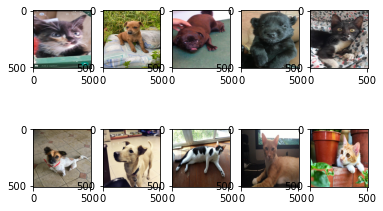

In [68]:
fig = plt.figure()
k = 1
for i in range(len(x_train[:10])):
    img = x_train[i]
    ax = fig.add_subplot(2,5,k)
    ax.imshow(img)
    k+=1

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)
val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)